In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# data prep
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# nltk.download("stopwords")
# nltk.download("punkt")
# nltk.download("wordnet")

# model training
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report


In [2]:
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# checking for missing values
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [5]:
# checking the distribution of sentiment class
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

## Basic Text Statistics (Word Count & Sentence Length)

In [6]:
df["word_count"] = df["review"].apply(lambda x: len(str(x).split()))
df["char_count"] = df["review"].apply(lambda x: len(str(x)))
df["sentence_count"] = df["review"].apply(lambda x: len(str(x).split(".")))

print("Basic Text Statistics:\n")
df[["word_count", "char_count", "sentence_count"]].describe()

Basic Text Statistics:



,word_count,char_count,sentence_count
count,50000.000000,50000.000000,50000.000000
mean,231.156940,1309.431020,14.010400
std,171.343997,989.728014,9.890968
min,4.000000,32.000000,1.000000
25%,126.000000,699.000000,8.000000
50%,173.000000,970.000000,11.000000
75%,280.000000,1590.250000,17.000000
max,2470.000000,13704.000000,176.000000


In [7]:
total_words = df["word_count"].sum()
print(f"Total words in dataset: {total_words}")

Total words in dataset: 11557847


## "review" column preprocessing pipeline
this process will include:
* Converting to lowercase
* Removing special characters, punctuation, and numbers
* Tokenizing
* Removing stopwords
* Lemmatizing

P.S. Tokenizing means breaking text into smaller parts, usually words or sentences, to make it easier to analyze. <br>Lemmatizing reduces words to their base or dictionary form (e.g., running → run), helping models understand different variations of the same word. Both techniques improve text processing by making data cleaner and more structured for machine learning.

In [8]:
from bs4 import BeautifulSoup

def clean_text(text):
    # removing HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    return text

df["review"] = df["review"].apply(clean_text)

In [9]:
# defining stopwords, lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# cleaning function
def preprocess_text(text):
    # converting to lowercase
    text = text.lower()
    
    # removing special characters, numbers, and punctuation
    text = re.sub(r"[^a-z\s]", "", text)
    
    # tokenizing the text
    tokens = word_tokenize(text)
    
    # removing stopwords and apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # joining tokens back into a string
    return " ".join(tokens)

In [10]:
df["cleaned_review"] = df["review"].apply(preprocess_text)
df[["review", "cleaned_review"]].head()

,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode you...
1,A wonderful little production. The filming tec...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


### Check the prep results

In [11]:
df["original_length"] = df["review"].apply(len)
df["cleaned_length"] = df["cleaned_review"].apply(len)

# length statistics comparison
df[["original_length", "cleaned_length"]].describe()

,original_length,cleaned_length
count,50000.000000,50000.000000
mean,1285.190240,819.542460
std,971.155366,632.153317
min,32.000000,17.000000
25%,689.000000,429.000000
50%,953.000000,603.000000
75%,1559.000000,998.000000
max,13584.000000,9182.000000


In [12]:
from collections import Counter

# getting most common words in original and cleaned text
original_words = Counter(" ".join(df["review"]).split()).most_common(20)
cleaned_words = Counter(" ".join(df["cleaned_review"]).split()).most_common(20)

print("Top 20 words in Original Reviews:\n", original_words)
print("\nTop 20 words in Cleaned Reviews:\n", cleaned_words)

Top 20 words in Original Reviews:
 [('the', 568758), ('a', 306961), ('and', 301931), ('of', 283626), ('to', 261851), ('is', 203056), ('in', 169983), ('I', 133367), ('that', 126818), ('this', 113733), ('it', 107920), ('was', 92658), ('as', 83132), ('with', 82569), ('for', 80920), ('The', 68906), ('but', 66286), ('on', 61197), ('movie', 60762), ('are', 56513)]

Top 20 words in Cleaned Reviews:
 [('movie', 99026), ('film', 89809), ('one', 52677), ('like', 39790), ('time', 29397), ('good', 28615), ('character', 27573), ('get', 24435), ('even', 24286), ('story', 24229), ('would', 24001), ('make', 23565), ('see', 23494), ('really', 22900), ('scene', 20706), ('much', 18897), ('well', 18629), ('people', 17979), ('great', 17803), ('bad', 17673)]


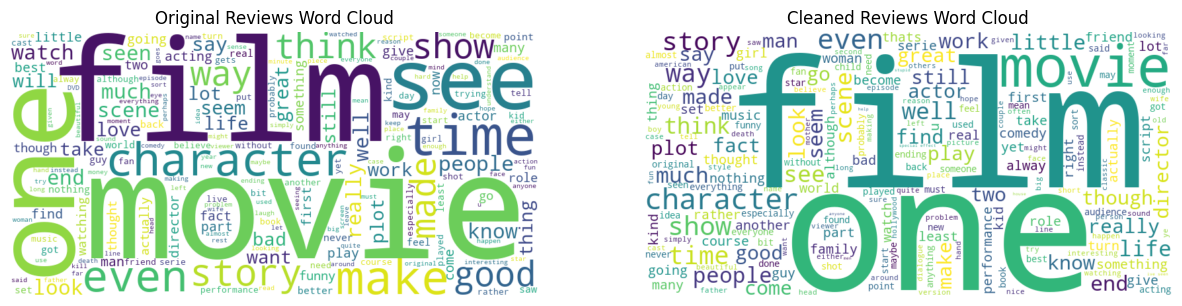

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud_original = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df["review"]))
wordcloud_cleaned = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df["cleaned_review"]))

# plotting side-by-side comparison
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].imshow(wordcloud_original, interpolation="bilinear")
ax[0].set_title("Original Reviews Word Cloud")
ax[0].axis("off")

ax[1].imshow(wordcloud_cleaned, interpolation="bilinear")
ax[1].set_title("Cleaned Reviews Word Cloud")
ax[1].axis("off")

plt.show()

## Train a Model
Simple Naive Bayes / Logistic Regression Model

We use Naive Bayes because it's a simple, fast, and effective algorithm for text classification, especially when features (words) are independent, which is often assumed in NLP tasks. Logistic Regression is used because it's a strong baseline model for binary classification (positive vs. negative), performs well with high-dimensional text data, and outputs interpretable probabilities. Both models work well with small to medium-sized datasets and are computationally efficient compared to deep learning methods.

In [14]:
# converting sentiment to binary (0: Negative, 1: Positive)
df["sentiment"] = df["sentiment"].map({"negative": 0, "positive": 1})

# split data
X_train, X_test, y_train, y_test = train_test_split(df["review"], df["sentiment"], test_size=0.2, random_state=42)

# TF-IDF vectorization
# This removes common English stopwords and keeps only the top 5,000 most important words from the dataset. 
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)

# This learns the vocabulary from X_train and transforms it into a matrix where each row represents a review as a set of weighted word features.
X_train_tfidf = vectorizer.fit_transform(X_train)

# This transforms X_test using the same learned vocabulary from X_train, ensuring consistency between train and test data.
X_test_tfidf = vectorizer.transform(X_test)

In [15]:
# verifying that the vectorizer has learned something from the training data
# print(vectorizer.vocabulary_)

In [16]:
# train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_preds = nb_model.predict(X_test_tfidf)

# train Logistic Regression
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_tfidf, y_train)
lr_preds = lr_model.predict(X_test_tfidf)

Even if we already removed stopwords using NLTK, TF-IDF is still useful for several reasons:

* **Weighting Important Words** – TF-IDF assigns higher importance to words that appear frequently in a document but not in all documents, making it better at distinguishing meaningful terms.

* **Handling Word Frequency Differences** – Some words (even after stopword removal) appear very frequently but might not be important. TF-IDF helps reduce their impact by giving lower weights to overly common words.

* **Feature Representation for ML Models** – Machine learning models can't work with raw text, so we need numerical features. TF-IDF converts text into a sparse matrix of weighted word frequencies, which is more informative than simple word counts.

In [17]:
# evaluation
print("Naive Bayes:")
print(classification_report(y_test, nb_preds))

print("\nLogistic Regression:")
print(classification_report(y_test, lr_preds))

Naive Bayes:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

